In [1]:
#@ author: Shamsulhaq Basir
#@ email: shamsbasir@gmail.com

In [2]:
%reset -f
import os
import torch
import numpy as np
from tqdm import tqdm
from numpy import vectorize
from torch.optim import Adam, LBFGS


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec

from utility.net_plotter import *

torch.set_default_dtype(torch.float64)
# for reproducibility purposes we provide a seed
np.random.seed(1)
torch.manual_seed(1)

In [3]:
print(torch.cuda.is_available())
print(torch.__version__)

False
1.12.1


In [4]:
class ConventBlock(torch.nn.Module):
    def __init__(self,in_N,out_N):
        super(ConventBlock, self).__init__()
        self.Ls  = None 
        self.net =torch.nn.Sequential(torch.nn.Linear(in_N,out_N),torch.nn.Tanh())
    def forward(self, x):
        out = self.net(x)
        return out 

In [5]:
class Network(torch.nn.Module):
    def __init__(self,layers,**kwargs):
        super(Network,self).__init__()
        self.mu  = kwargs["mean"]
        self.std = kwargs["stdev"]
        _layers = [] 
        for i in range(0,len(layers)-2):
            _layers.append(ConventBlock(layers[i],layers[i+1]))
        _layers.append(torch.nn.Linear(layers[-2],layers[-1]))
        self.net = torch.nn.Sequential(*_layers)
        
    def forward(self,x):
        # normalize the input
        x = (x - self.mu)/self.std
        o = self.net(x)
        u = o[:,0].reshape(-1,1)
        s = o[:,1].reshape(-1,1)
        return u,s
        
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_normal_(m.weight.data)
        torch.nn.init.zeros_(m.bias)

In [6]:
global alpha,v
v,alpha  = torch.tensor(1.0), torch.tensor(1e-6)

def u_exact(x):
    return torch.exp(-v * x/ alpha) / ( 1 - torch.exp(- v / alpha)) - 1./2.

# sigma = - alpha * u_x 
def sigma_exact(x):
    return v * alpha* torch.exp(-v * x/ alpha) / (alpha * ( 1 - torch.exp(- v / alpha)))

In [7]:
def fetch_boundary_points(domain=[0.0,1.0]):
    data = torch.tensor([[domain[0]],[domain[1]]])
    return data

In [8]:
# def fetch_residual_points(N_data,domain):
#     soboleng       = torch.quasirandom.SobolEngine(dimension=1,scramble=True)
#     data           = soboleng.draw(N_data,dtype=torch.float64)*(domain[1] - domain[0]) + domain[0] 
#     return data

def fetch_residual_points(N_data,domain):
    data = torch.linspace(domain[0],domain[1],N_data)[:,None]
    return data

In [9]:
def calc_pde_loss(phi,model,x):
    u,s = model(x)
    u_x  = torch.autograd.grad(u.sum(),x,create_graph=True)[0]
    s_x = torch.autograd.grad(s.sum(),x,create_graph=True)[0]
    physics_loss   = (v * u_x -  s_x).pow(2)
    flux_loss      = phi(s,- alpha * u_x)
    return physics_loss, flux_loss

In [10]:
def calc_boundary_loss(phi,model,x,ue):
    u,_   = model(x)
    loss  = phi_bc(u,ue)
    return loss

In [11]:
# user input:
kwargs ={"mean":0.50, "stdev":0.2887}     
layers = [1,20,20,20,20,2]
domain = [0.0,1.0]
model  = Network(layers,**kwargs)
model.apply(init_weights)

optimizer   = LBFGS(model.parameters(),line_search_fn="strong_wolfe")
#optimizer   = Adam(model.parameters(),lr=1e-2)

if type(optimizer).__name__ in ['Adam']:
    scheduler   = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.9,patience=100)

    
print(model)
print(model.mu)
print(model.std)

Network(
  (net): Sequential(
    (0): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=1, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (1): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (2): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (3): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)
0.5
0.2887


In [12]:
sum([p.numel() for p in model.parameters()])

1342

In [13]:
def evaluate(model,domain):
    x_test = torch.linspace(domain[0],domain[1],128)[:,None]
    u_test = u_exact(x_test)
    u_pred,_ = model(x_test)
    
    u_l2    = torch.linalg.norm(u_test - u_pred.detach(), 2)/torch.linalg.norm(u_test, 2)
    u_linf  = torch.linalg.norm(u_test - u_pred.detach(), float('inf'))
    
    return u_l2,u_linf

In [14]:
# generating points for boundary condition
x_bc    = fetch_boundary_points(domain)
u_bc    = u_exact(x_bc)

x_dm    = fetch_residual_points(2048,domain)
x_dm    = x_dm.requires_grad_(True)

In [15]:
phi_bc     = torch.nn.MSELoss(reduction='none')
phi_flux   = torch.nn.MSELoss(reduction='none')

In [16]:
epochs          = 5000
disp_epoch      = 500
print_to_consol = True

lambda_flux  = torch.ones_like(x_dm)
lambda_bc    = torch.ones_like(x_bc)

v_flux      = torch.zeros_like(x_dm)
v_bc        = torch.zeros_like(x_bc)

moment       = 0.9
lr           = 1e-2

for epoch in tqdm(range(1,epochs+1)):

    def closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()

        # calculating reformulated pde loss
        physics_loss,flux_res = calc_pde_loss(phi_flux,model,x_dm)
        
        flux_loss       = (lambda_flux * flux_res).sum()
        # approximating boundary constraints
        boundary_res = calc_boundary_loss(phi_bc,model,x_bc,u_bc)

        # approximating boundary loss 
        boundary_loss   = (lambda_bc  * boundary_res).sum()
        # total loss 
        loss      = physics_loss.sum() + flux_loss  + boundary_loss 

        if loss.requires_grad:
            loss.backward()
        return loss

    def _closure():

        model.eval()

        # calculating reformulated pde loss
        physics_loss,flux_res = calc_pde_loss(phi_flux,model,x_dm)

        # approximating boundary constraints
        boundary_res = calc_boundary_loss(phi_bc,model,x_bc,u_bc)

        return physics_loss.sum(),flux_res, boundary_res
    

    optimizer.step(closure)
    physics_loss,flux_res, boundary_res = _closure()
        
    with torch.no_grad():
        v_bc    = (1.0 - moment) * boundary_res.pow(2) + moment * v_bc
        v_flux  = (1.0 - moment) * flux_res.pow(2)     + moment * v_flux
        
        lambda_bc    += lr / ( v_bc   + 1e-10).sqrt()   * boundary_res
        lambda_flux  += lr / ( v_flux + 1e-10).sqrt()   * flux_res

        if epoch%disp_epoch == 0 and print_to_consol:
            u_l2,u_linf = evaluate(model,domain)
            print(f"epoch : {epoch},u l2 : {u_l2:2.2e}, u linf : {u_linf:2.2e}")
            print(f"epoch :{epoch:5d}, total physics loss :{physics_loss.item():2.3e}")

u_l2,u_linf = evaluate(model,domain)
print(f"epoch : {epoch},u l2 : {u_l2:2.2e}, u linf : {u_linf:2.2e}")
file = f"models/Proposed_model.pt"
torch.save(model.state_dict(),file)

# saving the lagrange multipliers 
file = f"LagrangeMultiplier/Lambda_bc_proposed"
np.save(file, lambda_bc)

file = f"LagrangeMultiplier/Lambda_flux_proposed"
np.save(file, lambda_flux)

 10%|█         | 500/5000 [02:03<17:46,  4.22it/s]

epoch : 500,u l2 : 7.94e-01, u linf : 4.05e-01
epoch :  500, total physics loss :2.451e-02


 20%|██        | 1000/5000 [04:41<16:38,  4.01it/s] 

epoch : 1000,u l2 : 6.92e-01, u linf : 3.49e-01
epoch : 1000, total physics loss :1.470e-02


 30%|███       | 1500/5000 [06:50<14:31,  4.02it/s]

epoch : 1500,u l2 : 9.96e-03, u linf : 1.60e-02
epoch : 1500, total physics loss :3.347e-01


 40%|████      | 2000/5000 [08:52<12:23,  4.04it/s]

epoch : 2000,u l2 : 3.90e-03, u linf : 4.18e-03
epoch : 2000, total physics loss :5.752e-02


 50%|█████     | 2500/5000 [11:15<11:59,  3.47it/s]

epoch : 2500,u l2 : 2.16e-03, u linf : 1.39e-03
epoch : 2500, total physics loss :1.258e-02


 60%|██████    | 3004/5000 [13:00<01:31, 21.93it/s]

epoch : 3000,u l2 : 5.14e-04, u linf : 3.18e-04
epoch : 3000, total physics loss :1.375e-03


 70%|███████   | 3508/5000 [13:56<02:07, 11.74it/s]

epoch : 3500,u l2 : 1.28e-04, u linf : 1.43e-04
epoch : 3500, total physics loss :1.058e-03


 80%|████████  | 4009/5000 [14:20<00:56, 17.58it/s]

epoch : 4000,u l2 : 2.15e-04, u linf : 1.68e-04
epoch : 4000, total physics loss :9.504e-04


 90%|█████████ | 4505/5000 [15:00<00:08, 59.90it/s]

epoch : 4500,u l2 : 3.10e-05, u linf : 5.29e-05
epoch : 4500, total physics loss :8.328e-04


100%|██████████| 5000/5000 [15:16<00:00,  5.46it/s]

epoch : 5000,u l2 : 3.11e-05, u linf : 4.75e-05
epoch : 5000, total physics loss :8.584e-04
epoch : 5000,u l2 : 3.11e-05, u linf : 4.75e-05


In [23]:
# https://joseph-long.com/writing/colorbars/
def colorbar(mappable,min_val,max_val,limit):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    ticks = np.linspace(min_val, max_val, 4, endpoint=True)
    cbar = fig.colorbar(mappable, cax=cax,ticks=ticks)
    cbar.formatter.set_powerlimits((limit, limit))
    plt.sca(last_axes)
    return cbar

params = {
    'text.latex.preamble': '\\usepackage{gensymb}',
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels
    'axes.titlesize': 24,
    'font.size'     : 20, 
    'legend.fontsize': 18, 
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex': False,
    'figure.figsize': [4, 4],
    'font.family': 'serif',
}
plt.rcParams.update(params)
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cmap = plt.cm.get_cmap(cmap_list[8]).reversed()

In [31]:
file = f"models/Proposed_model.pt"
model.load_state_dict(torch.load(file))

# loading the lagrange multipliers 
file = f"LagrangeMultiplier/Lambda_bc_proposed.npy"
lambda_bc = torch.from_numpy(np.load(file))

file = f"LagrangeMultiplier/Lambda_flux_proposed.npy"
lambda_flux = torch.from_numpy(np.load(file))


In [32]:
# create the coordinates
numebr_of_points = 128 ; small_range = -1.0 ; large_range =  1.0
xcoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 
ycoordinates = np.linspace(small_range, large_range, num=numebr_of_points) 
xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)

# get two random directions with filter normalization 
weights           = get_weights(model)

# pick random direction one
random_direction1 = create_random_direction(model)

# pick random direction two
random_direction2 = create_random_direction(model)

directions        = [random_direction1,random_direction2]

# calculating loss values 
loss_list = np.zeros((numebr_of_points,numebr_of_points))

for row in range(numebr_of_points):
    
    for col in range(numebr_of_points):
        
        step_x = xcoord_mesh[row][col]
        step_y = ycoord_mesh[row][col]
        step   = [step_x, step_y]

        #updating the weights of the model 
        set_weights(model,weights,directions,step)

        physics_loss,flux_res = calc_pde_loss(phi_flux,model,x_dm)
        
        flux_loss       = (lambda_flux * flux_res).sum()
        # approximating boundary constraints
        boundary_res = calc_boundary_loss(phi_bc,model,x_bc,u_bc)

        # approximating boundary loss 
        boundary_loss   = (lambda_bc  * boundary_res).sum()
        # total loss 
        loss      = physics_loss.sum() + flux_loss  + boundary_loss 

        with torch.no_grad():
            loss_list[row][col] = loss.item()

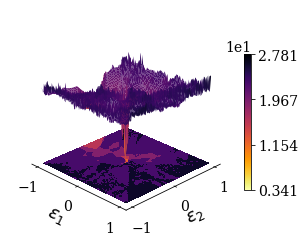

In [36]:
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cm = plt.cm.get_cmap(cmap_list[6]).reversed()

gs = gridspec.GridSpec(1, 1)
gs.update(wspace=0.1)

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(gs[0,0],projection='3d')
# Remove gray panes and axis grid
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.fill = False
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.fill = False
ax.zaxis.pane.set_edgecolor('white')
ax.grid(False)

# Remove z-axis
ax.w_zaxis.line.set_lw(0.)
ax.set_zticks([])

vmax = np.max(np.log(loss_list+1e-14))
vmin = np.min(np.log(loss_list+1e-14))
plot = ax.plot_surface(xcoord_mesh, 
                       ycoord_mesh,
                       np.log(loss_list+1e-14),
                       cmap=cm,
                       linewidth=0, 
                       vmin=vmin,
                       vmax=vmax)

cset = ax.contourf(xcoord_mesh, 
                   ycoord_mesh,
                   np.log(loss_list+1e-14),
                   zdir='z', 
                   offset=np.min(np.log(loss_list+1e-14)-0.2), 
                   cmap=cm)

# Adjust plot view
ax.view_init(elev=25, azim=-45)
ax.dist=11
ticks = np.linspace(vmin, vmax, 4, endpoint=True)
cbar = fig.colorbar(plot, ax=ax, shrink=0.50,ticks=ticks,pad=0.02)
cbar.formatter.set_powerlimits((1, 1))

# Set tick marks
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))

# Set axis labels
ax.set_xlabel(r"$\epsilon_1$");
ax.set_ylabel(r"$\epsilon_2$");
# Set z-limit
ax.set_zlim(vmin, vmax);

#ax.set_title('Proposed model',fontsize=12)
filename = f"figures/loss_landscape_Proposed_{type(optimizer).__name__}"
plt.savefig('{}.png'.format(filename), bbox_inches='tight', pad_inches=0.2)
plt.show()

Model trained with Adam not found
 Model trained with LBFGS optimizer : u l2 : 1.66e-04, u linf : 2.94e-04


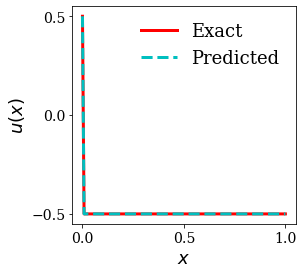

In [34]:
# testing and saving L_2r and L_inf
fig = plt.figure(figsize=(4,4))

gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[0,0])
x_test = torch.linspace(domain[0],domain[1],128)[:,None]
u_test = u_exact(x_test)
ax.plot(x_test,u_test,'-r',label='Exact',linewidth=3)
try:
    file = f"models/Proposed_Adam.pt"
    model.load_state_dict(torch.load(file))
    u_pred_Adam,_  = model(x_test)

    u_l2    = torch.linalg.norm(u_test - u_pred_Adam.detach(), 2)/torch.linalg.norm(u_test, 2)
    u_linf  = torch.linalg.norm(u_test - u_pred_Adam.detach(), float('inf'))
    print(f" Model trained with Adam optimizer : u l2 : {u_l2:2.2e}, u linf : {u_linf:2.2e}")
    ax.plot(x_test,u_pred_Adam.detach(),'-.b',label='Predicted (Adam)',linewidth=3)

except:
    print("Model trained with Adam not found")
    

try:
    file = f"models/Proposed_LBFGS.pt"
    model.load_state_dict(torch.load(file))
    u_pred_LBFGS,_  = model(x_test)

    u_l2    = torch.linalg.norm(u_test - u_pred_LBFGS.detach(), 2)/torch.linalg.norm(u_test, 2)
    u_linf  = torch.linalg.norm(u_test - u_pred_LBFGS.detach(), float('inf'))
    print(f" Model trained with LBFGS optimizer : u l2 : {u_l2:2.2e}, u linf : {u_linf:2.2e}")
    
    ax.plot(x_test,u_pred_LBFGS.detach(),'--c',label='Predicted',linewidth=3)

except:
    print("Model trained with LBFGS not found")
    


ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$')
ax.set_yticks([-0.5,0.,0.5])
ax.set_xticks([0.,0.5,1.0])
plt.legend(frameon=False,loc='upper right',ncol=1)
filename =f"figures/Proposed_u"
plt.savefig('{}.png'.format(filename), bbox_inches='tight', pad_inches=0.02)
plt.show() 


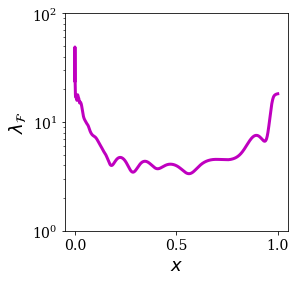

In [30]:
# testing and saving L_2r and L_inf
fig = plt.figure(figsize=(4,4))

gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[0,0])
ax.semilogy(x_dm.detach(),lambda_flux,'-m',label='$\lambda_{\mathcal{F}}$',linewidth=3)
ax.set_ylabel('$\lambda_{\mathcal{F}}$')
ax.set_xlabel('$x$')
ax.set_yticks([1e0,1e1,1e2])
ax.set_xticks([0.,0.5,1.0])
# plt.legend(frameon=False,loc='upper right',ncol=1)
filename =f"figures/Proposed_lambda_flux"
plt.savefig('{}.png'.format(filename), bbox_inches='tight', pad_inches=0.02)
plt.show() 